In [359]:
#%matplotlib notebook
#%matplotlib widget
%matplotlib inline
from openocd import OpenOcd
import matplotlib.pyplot as plt
import math
from IPython.display import Image
import struct
import time


""" --------------------------------------------
    -------------- Read ECG file ---------------
    -------------------------------------------- """
def read_ecg(filename):
    with open(filename, 'rb') as f: # read binary
        ch_0 = []   # Channel 0 data
        ch_1 = []   # Channel 1 data
        ch_comb = []
        
        while True:
            byte = f.read(1)
            if byte == b'\x00':
                break
                
        while True:
            # Was haben die Samples wirklich für ein Format?
            word = f.read(4)

            if len(word) == 4:
                # struct.unpack(format, buffer): The result is a tuple (a,b,...) even if it contains exactly one item.
                # The buffer’s size in bytes must match the size required by the format, as reflected by calcsize().
                # [>]-big-endian; [h]-short, from C short to Python integer, standard size 2 bytes.
                d_0, d_1 = struct.unpack('>hh', word)
                
                ch_0.append(d_0)
                ch_1.append(d_1)
                
                ds = struct.unpack('>I', word)    # I: Unsigned int (size: 4 bytes) 
                ch_comb.append(ds[0])
            #elif len(word) == 4 and f.peek(8) == b'':   # Last data can be 4 bytes large
            #    ch_0.append(struct.unpack('>i', word)[0])
            #    break
            else:   
                break

        return (ch_0, ch_1, ch_comb)


""" --------------------------------------------
    -------------- Progress Bar ---------------
    -------------------------------------------- """
def progressbar(percent):
    p = math.ceil(percent / 2)
    b = min([50 - p, 50])
    print('\r[' + ('=' * p) + (' ' * b) + ']', end='')


""" --------------------------------------------
    ------- Write/Read directly to CAECO -------
    -------------------------------------------- """
def caeco_dmi(ocd, data):
    print("\nWriting data directly to CAECO")
    init_res = ocd.send(openocd_dmi_read(0x24))
    print(f"Initial Caeco result: {init_res}".strip())

    print("\nWriting CMD commands")
    ocd.send(openocd_dmi_write(0x23, "0x4"))  # first write to this address specifies direct access
    ocd.send(openocd_dmi_write(0x23, "0x10")) # reset     caeco(  .RSTN((~rst) & caecoif_ctrl_r[4]), ) (in caecointerface.v)
    ocd.send(openocd_dmi_write(0x23, "0x11")) # if CMD = "01" then start computing (in caeco.vh)

    print("\nWriting ECG data...")
    len_data = int(len(chs)/4)   # Reduced for verification, DO NOT try with not enough data
    progressbar(0)
    for i in range(len_data):
        ocd.send(openocd_dmi_write(0x22, hex(data[i])))
        if i % 1000 == 999:
            progressbar(i * 100 / len_data)
    progressbar(100)
    
    print("\nWriting CMD to indicate last ECG value")
    ocd.send(openocd_dmi_write(0x23, "0x18")) # b'11000   caeco(  .DIN_LAST(caecoif_ctrl_r[3]), ) (in caecointerface.v)

    print("\nCalculating...")
    time.sleep(1)
    res = ocd.send(openocd_dmi_read(0x24))
    print(f"New Caeco result: {res}".strip())
    if res.strip() == '0x1':
        print('Result: Krank')
        display(Image(filename='rot.png'))
    else:
        print('Result: Gesund')
        display(Image(filename='gruen.png'))
    return res.strip()


""" --------------------------------------------
    ------ Write/Read to CAECO via RISC-V ------
    -------------------------------------------- """
def caeco_mcu(ocd, data):
    print("\nWriting data via RISC-V")
    addr, init_res = openocd_read_mem(ocd, 0xc00000c0)
    print(f"Reading address: {addr}".strip())
    print(f"Initial Caeco result: {init_res}".strip())

    print("\nWriting CMD commands")
    openocd_write_mem(ocd, 0xc0000011, "0xF")  # first write to this address specifies access via RISC-V, but caecoif_ctrl_r[4] =! 1
    openocd_write_mem(ocd, 0xc0000011, "0x10") # reset     caeco(  .RSTN((~rst) & caecoif_ctrl_r[4]), ) (in caecointerface.v)
    openocd_write_mem(ocd, 0xc0000011, "0x11") # if CMD = "01" then start computing (in caeco.vh)
    
    print("\nWriting ECG data...")
    len_data = int(len(chs)/4)   # Reduced for verification, DO NOT try with not enough data
    progressbar(0)
    for i in range(len_data):
        openocd_write_mem(ocd, 0xc0000010, hex(data[i]))
        if i % 1000 == 999:
            progressbar(i * 100 / len_data)
    progressbar(100)
    
    print("\nWriting CMD to indicate last ECG value")
    openocd_write_mem(ocd, 0xc0000011, "0x18") # b'11000   caeco(  .DIN_LAST(caecoif_ctrl_r[3]), ) (in caecointerface.v)

    print("\nCalculating...")
    time.sleep(1)
    addr, res = openocd_read_mem(ocd, 0xc00000c0)
    print(f"Reading address: {addr}".strip())
    print(f"New Caeco result: {res}".strip())
    if res.strip() == '0x1':
        print('Result: Krank')
        display(Image(filename='rot.png'))
    else:
        print('Result: Gesund')
        display(Image(filename='gruen.png'))
    return res.strip()


""" --------------------------------------------
    ------------ W/R to MEM via DMI ------------
    -------------------------------------------- """
def openocd_write_mem(ocd, maddr, mwdata):   # From jtag_tasks.vh
    ocd.send(openocd_dmi_write(0x10, "0x80000000"))

    ocd.send(openocd_dmi_write(0x20, "0x00942023")) # sw s1, s0(0)   - 0000 0000 1001 0100 0010 0000 0010 0011 - 00942023
    ocd.send(openocd_dmi_write(0x21, "0x00440413")) # addi s0, s0, 4 - 0000 0000 0100 0100 0000 0100 0001 0011 - 00440413
    ocd.send(openocd_dmi_write(0x04, maddr))
    ocd.send(openocd_dmi_write(0x17, "0x00231008"))
    ocd.send(openocd_dmi_write(0x04, mwdata))
    ocd.send(openocd_dmi_write(0x17, "0x00271009"))

def openocd_read_mem(ocd, maddr):  # From jtag_tasks.vh
    ocd.send(openocd_dmi_write(0x10, "0x80000000"))
    
    ocd.send(openocd_dmi_write(0x20, "0x00042403"))
    ocd.send(openocd_dmi_write(0x21, "0x00100073"))
    ocd.send(openocd_dmi_write(0x04, maddr))
    addr = ocd.send(openocd_dmi_read(0x04))
    ocd.send(openocd_dmi_write(0x17, "0x00271008"))
    ocd.send(openocd_dmi_write(0x17, "0x00221008"))
    res = ocd.send(openocd_dmi_read(0x04))
    return (addr, res)


""" --------------------------------------------
    ----- W/R OpenOCD RISC-V DMI Commands ------
    -------------------------------------------- """
def openocd_dmi_write(address, data):
    return f"riscv dmi_write {address} {data}"

def openocd_dmi_read(address):
    return f"riscv dmi_read {address}"

In [360]:
""" ------ Connection with OpenOCD ------ """
o = OpenOcd()
o.connect()

In [361]:
""" ------ DATA SET ------ """
krank_path = 'C:\\Users\\sgarcia\\Documents\\GitLab\\caeco\\sim\\ecg\\krank\\'
gesund_path = 'C:\\Users\\sgarcia\\Documents\\GitLab\\caeco\\sim\\ecg\\gesund\\'

""" NOTES:
Krank files giving Gesund result:
krank[6] 00299eac-4be8-4a5a-a20f-c319bc50f43a.ecg

Gesund files giving Krank result:
gesund[1] 009a9579-bdec-49e5-9a38-9cfe615dd5ec.ecg
gesund[7] 0093a604-768a-4c56-9910-dca8dd9f3234.ecg
gesund[11] 0075247d-2554-47fd-8351-954748045855.ecg

gesund[4] len(data)/4 not enough
gesund[13] len(data)/4 not enough
krank[10] len(data)/4 not enough
krank[11] len(data)/4 not enough
krank[13] len(data)/4 not enough
"""
krank = [krank_path + '9c3b11f4-697f-4283-8fd8-7ea1bcd7be9f.ecg', \
         krank_path + '0013b1f5-a710-48ec-b5af-17fc367da4df.ecg', \
         krank_path + '00019fb0-6b6a-4ccf-b818-b52221ec524c.ecg', \
         krank_path + '0021c27e-92a0-478a-9367-2cc125cd0d1c.ecg', \
         krank_path + '0041d003-2632-4d83-bde7-9071eb7d876a.ecg', \
         krank_path + '42ac1da8-1a2e-41ed-bff6-4fe31ab3c0a7.ecg', \
         krank_path + '00299eac-4be8-4a5a-a20f-c319bc50f43a.ecg', \
         krank_path + '00311fdc-f402-4c6f-aa5a-0c723e35421f.ecg', \
         krank_path + '00327b67-8d33-4fa5-bb21-db88bc27d4df.ecg', \
         krank_path + '00373ff3-1075-44c7-80f2-eaf57f0c5047.ecg', \
         krank_path + '002430bb-9ca6-46d6-8286-44e1a5baeeb5.ecg', \
         krank_path + '0048920f-c1d7-4e2f-9cc5-27df10ed9171.ecg', \
         krank_path + 'cf4c5ac3-0081-4036-b2e1-2e7fe933f67e.ecg', \
         krank_path + 'f1a5e4e3-bdee-47b0-8eb1-8a8a53ba1e41.ecg']

gesund = [gesund_path + '008dd4d5-4fda-4af9-b75c-0691078980b5.ecg', \
          gesund_path + '009a9579-bdec-49e5-9a38-9cfe615dd5ec.ecg', \
          gesund_path + '42c68bc8-795c-4ec9-b39c-38974479b45c.ecg', \
          gesund_path + '0071a579-9989-41e7-87c4-dfe345be9dd3.ecg', \
          gesund_path + '0078bf73-67fe-46bf-ad5b-5d1640c8e3d6.ecg', \
          gesund_path + '82ef0b16-f7bf-4128-af90-d2b4f1b29a68.ecg', \
          gesund_path + '0084adb4-416a-4a53-b1a2-cdc3e587428e.ecg', \
          gesund_path + '0093a604-768a-4c56-9910-dca8dd9f3234.ecg', \
          gesund_path + '00126a27-37fd-4530-b347-40dcbf2ef9bc.ecg', \
          gesund_path + '008789b1-a34e-4dad-acdc-4436f890b387.ecg', \
          gesund_path + '0042963c-f4d8-4493-9de5-76feba2faaf2.ecg', \
          gesund_path + '0075247d-2554-47fd-8351-954748045855.ecg', \
          gesund_path + 'bd14f7d8-3403-480e-b67e-a2e9baea03f6.ecg', \
          gesund_path + 'f3a320ea-f828-4f36-87ac-3f66fe9c3990.ecg', \
         ]



""" ------ DATA SET FOR VERIFICATION ------ """
# This files have been tested to achieve the correct result using only 1/4 of the data to speed verification.
# Not using enough data can lead to an incorrect result.
ver_krank = [krank_path + '9c3b11f4-697f-4283-8fd8-7ea1bcd7be9f.ecg', \
         krank_path + '0013b1f5-a710-48ec-b5af-17fc367da4df.ecg', \
         krank_path + '00019fb0-6b6a-4ccf-b818-b52221ec524c.ecg', \
         krank_path + '0021c27e-92a0-478a-9367-2cc125cd0d1c.ecg', \
         krank_path + '0041d003-2632-4d83-bde7-9071eb7d876a.ecg', \
         krank_path + '42ac1da8-1a2e-41ed-bff6-4fe31ab3c0a7.ecg', \
        # krank_path + '00299eac-4be8-4a5a-a20f-c319bc50f43a.ecg', \
         krank_path + '00311fdc-f402-4c6f-aa5a-0c723e35421f.ecg', \
         krank_path + '00327b67-8d33-4fa5-bb21-db88bc27d4df.ecg', \
         krank_path + '00373ff3-1075-44c7-80f2-eaf57f0c5047.ecg', \
        # krank_path + '002430bb-9ca6-46d6-8286-44e1a5baeeb5.ecg', \
        # krank_path + '0048920f-c1d7-4e2f-9cc5-27df10ed9171.ecg', \
         krank_path + 'cf4c5ac3-0081-4036-b2e1-2e7fe933f67e.ecg', \
        # krank_path + 'f1a5e4e3-bdee-47b0-8eb1-8a8a53ba1e41.ecg'
            ]

ver_gesund = [gesund_path + '008dd4d5-4fda-4af9-b75c-0691078980b5.ecg', \
         # gesund_path + '009a9579-bdec-49e5-9a38-9cfe615dd5ec.ecg', \
          gesund_path + '42c68bc8-795c-4ec9-b39c-38974479b45c.ecg', \
          gesund_path + '0071a579-9989-41e7-87c4-dfe345be9dd3.ecg', \
         # gesund_path + '0078bf73-67fe-46bf-ad5b-5d1640c8e3d6.ecg', \
          gesund_path + '82ef0b16-f7bf-4128-af90-d2b4f1b29a68.ecg', \
          gesund_path + '0084adb4-416a-4a53-b1a2-cdc3e587428e.ecg', \
         # gesund_path + '0093a604-768a-4c56-9910-dca8dd9f3234.ecg', \
          gesund_path + '00126a27-37fd-4530-b347-40dcbf2ef9bc.ecg', \
          gesund_path + '008789b1-a34e-4dad-acdc-4436f890b387.ecg', \
          gesund_path + '0042963c-f4d8-4493-9de5-76feba2faaf2.ecg', \
         # gesund_path + '0075247d-2554-47fd-8351-954748045855.ecg', \
          gesund_path + 'bd14f7d8-3403-480e-b67e-a2e9baea03f6.ecg', \
         # gesund_path + 'f3a320ea-f828-4f36-87ac-3f66fe9c3990.ecg', \
         ]

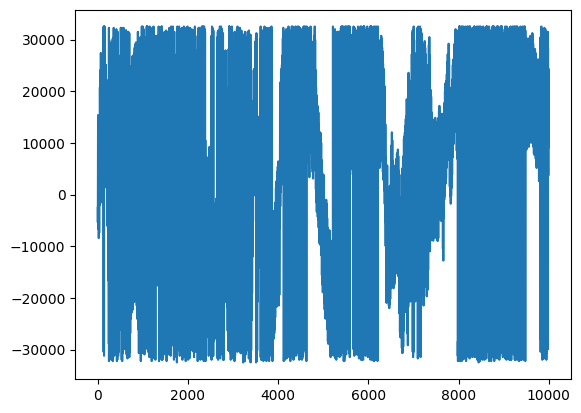

In [362]:
""" ------ READ and PLOT ECG ------ """
ch0, ch1, chs = read_ecg(ver_krank[5]) # ver_krank[0-9], ver_gesund[0-8]
plt.plot(ch0[1:10000])


Writing data directly to CAECO
Initial Caeco result: 0x1

Writing CMD commands

Writing ECG data...
[==================================================]
Writing CMD to indicate last ECG value

Calculating...
New Caeco result: 0x1
Result: Krank


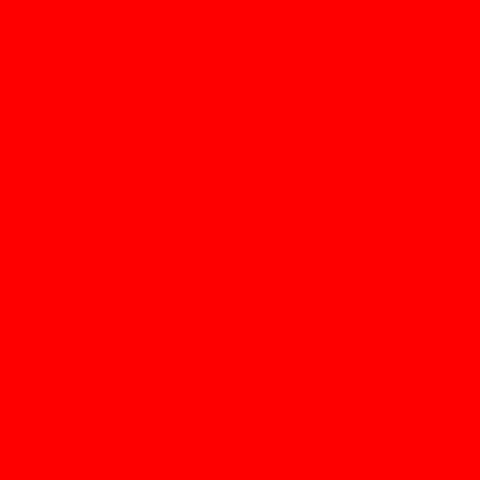

In [363]:
""" ------ W/R directly to CAECO ------ """
res = caeco_dmi(o, chs)


Writing data via RISC-V
Reading address: 0xc00000c0
Initial Caeco result: 0x0

Writing CMD commands

Writing ECG data...
[==================================================]
Writing CMD to indicate last ECG value

Calculating...
Reading address: 0xc00000c0
New Caeco result: 0x1
Result: Krank


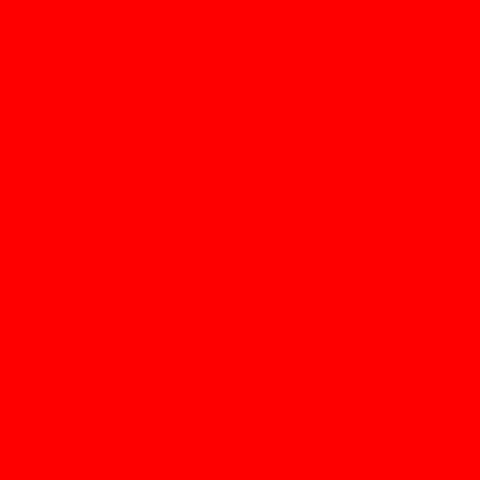

In [357]:
""" ------ W/R to CAECO via RISC-V ------ """
res = caeco_mcu(o, chs)